<a href="https://colab.research.google.com/github/ShoaibMuhammad123/Pytorch/blob/main/Pytorch10_Hyperparameter_using_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [ ]:
torch.manual_seed(42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
df = pd.read_csv('/content/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
x = df.iloc[:,1:]
y = df.iloc[:,0]

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.2,random_state=42)

In [ ]:
x_train = x_train/255
x_test = x_test/255

### Custom Dataset Class

In [ ]:
class CustomDataSet(Dataset):

  def __init__(self,features,labels):

    super().__init__()

    self.features = torch.tensor(np.array(features),dtype=torch.float32)
    self.labels = torch.tensor(np.array(labels),dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index],self.labels[index]



In [ ]:
train_dataset = CustomDataSet(x_train,y_train)
test_dataset = CustomDataSet(x_test,y_test)

In [ ]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True,pin_memory=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False,pin_memory=True)

## **Neural Network Class**

In [ ]:
class MyNN(nn.Module):
  def __init__(self,input_dim,output_dim,num_hidden_layers,neuron_per_layer):
    super().__init__()

    # we didn't know actually how many number of layer are enough
    layers = []

    for i in range(num_hidden_layers):

      layers.append(nn.Linear(input_dim,neuron_per_layer))
      layers.append(nn.BatchNorm1d(neuron_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(0.3))
      input_dim = neuron_per_layer

    layers.append(nn.Linear(neuron_per_layer,output_dim))

    self.model = nn.Sequential(*layers)  # sequential can't accept list to unpac the list we use *

  def forward(self,x):
    return self.model(x)



# **here our work start**

# **OBJECTIVE FUNCTION**

In [ ]:
def objective(trial):

  # next hyperparameter values from the search space

  num_hidden_layers = trial.suggest_int('num_hidden_layers',1,5)   # num of hidden layer b/w 1 and 5
  neuron_per_layer = trial.suggest_int('neuron_per_layer',8,128,step = 8)
  #model initialization(for model inital.. you need no of input dim and no of output dim)
  input_dim = 784
  output_dim = 10

  # object
  model = MyNN(input_dim,output_dim,num_hidden_layers,neuron_per_layer)
  model.to(device)  # sending model to gpu

  # params init
  learning_rate = 0.1
  epochs = 50


  # optimizer selection
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(),lr = learning_rate,weight_decay=1e-4)

  # trianing loop
  for epoch in range(epochs):

    total_epoch_loss=0
    for batch_features,batch_labels in train_loader:
      batch_features,batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward
      y_pred = model(batch_features)

      #loss calculation
      loss = criterion(y_pred,batch_labels)

      # back pass
      optimizer.zero_grad()
      loss.backward()

      # update grads
      optimizer.step()

      total_epoch_loss = total_epoch_loss + loss.item()


  # evaluation
  model.eval()

  total = 0
  correct =0

  with torch.no_grad():
    for batch_features,batch_labels in test_loader:

      batch_features,batch_labels = batch_features.to(device), batch_labels.to(device)

      y_pred = model(batch_features)

      _,predicted = torch.max(y_pred,1)

      total = total + batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()
  accuracy = correct/total

  return accuracy

# **STUDY CREATION**

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.3 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
study = optuna.create_study(direction='maximize')

[I 2025-02-24 20:47:53,671] A new study created in memory with name: no-name-3b03c237-f4af-4f60-9d51-9d78c3339f78


In [ ]:
study.optimize(objective,n_trials=10)

[I 2025-02-24 20:49:29,907] Trial 5 finished with value: 0.8204225352112676 and parameters: {'num_hidden_layers': 2, 'neuron_per_layer': 112}. Best is trial 2 with value: 0.8204225352112676.
[I 2025-02-24 20:49:42,820] Trial 6 finished with value: 0.801056338028169 and parameters: {'num_hidden_layers': 5, 'neuron_per_layer': 40}. Best is trial 2 with value: 0.8204225352112676.
[I 2025-02-24 20:49:52,066] Trial 7 finished with value: 0.7940140845070423 and parameters: {'num_hidden_layers': 3, 'neuron_per_layer': 32}. Best is trial 2 with value: 0.8204225352112676.
[I 2025-02-24 20:50:01,828] Trial 8 finished with value: 0.823943661971831 and parameters: {'num_hidden_layers': 3, 'neuron_per_layer': 112}. Best is trial 8 with value: 0.823943661971831.
[I 2025-02-24 20:50:14,445] Trial 9 finished with value: 0.8045774647887324 and parameters: {'num_hidden_layers': 5, 'neuron_per_layer': 64}. Best is trial 8 with value: 0.823943661971831.
[I 2025-02-24 20:50:25,566] Trial 10 finished with v

In [ ]:
study.best_value

0.823943661971831

In [ ]:
study.best_params

{'num_hidden_layers': 3, 'neuron_per_layer': 112}

# **Hyperparameter tuning of the reamining six parameters**

#### **Copying the above codes and modifying these**

## **CustomClassDataset**

In [ ]:
class CustomDataSet(Dataset):

  def __init__(self,features,labels):

    super().__init__()

    self.features = torch.tensor(np.array(features),dtype=torch.float32)
    self.labels = torch.tensor(np.array(labels),dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index],self.labels[index]



In [ ]:
train_dataset = CustomDataSet(x_train,y_train)
test_dataset = CustomDataSet(x_test,y_test)

# **MODEL**

In [ ]:
class MyNN(nn.Module):
  def __init__(self,input_dim,output_dim,num_hidden_layers,neuron_per_layer,dropout_rate):
    super().__init__()

    # we didn't know actually how many number of layer are enough
    layers = []

    for i in range(num_hidden_layers):

      layers.append(nn.Linear(input_dim,neuron_per_layer))
      layers.append(nn.BatchNorm1d(neuron_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neuron_per_layer

    layers.append(nn.Linear(neuron_per_layer,output_dim))

    self.model = nn.Sequential(*layers)  # sequential can't accept list to unpac the list

  def forward(self,x):
    return self.model(x)



# **Objective Function**

In [ ]:
def objective(trial):

  # next hyperparameter values from the search space

  num_hidden_layers = trial.suggest_int('num_hidden_layers',1,5)   # num of hidden layer b/w 1 and 5
  neuron_per_layer = trial.suggest_int('neuron_per_layer',8,128,step = 8)
  epochs = trial.suggest_int('epochs',10,50,step=10)
  learning_rate = trial.suggest_float('learning_rate',1e-5,1e-1,log=True)
  dropout_rate = trial.suggest_float('dropout_rate',0.3,0.5,step =0.1)
  batch_size = trial.suggest_categorical('batch_size',[16,32,64,128])
  optimizer_name = trial.suggest_categorical('optimizer',['Adam','SGD','RMSprop'])
  weight_decay = trial.suggest_float('weight_decay',1e-5,1e-3,log=True)


  train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,pin_memory=True)
  test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,pin_memory=True)



  #model initialization(for model inital.. you need no of input dim and no of output dim)
  input_dim = 784
  output_dim = 10

  model = MyNN(input_dim,output_dim,num_hidden_layers,neuron_per_layer,dropout_rate)
  model.to(device)  # sending model to gpu

  # params init
  # above defined epochs ,learning rate


  # optimizer selection
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(),lr = learning_rate,weight_decay=1e-4)

  if optimizer_name =='Adam':
    optim.Adam(model.parameters(),lr = learning_rate,weight_decay=weight_decay)
  elif optimizer_name =='SGD':
    optim.SGD(model.parameters(),lr = learning_rate,weight_decay=weight_decay)
  else:
    optim.RMSprop(model.parameters(),lr = learning_rate,weight_decay=weight_decay)

  # trianing loop
  for epoch in range(epochs):

    total_epoch_loss=0
    for batch_features,batch_labels in train_loader:
      batch_features,batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward
      y_pred = model(batch_features)

      #loss calculation
      loss = criterion(y_pred,batch_labels)

      # back pass
      optimizer.zero_grad()
      loss.backward()

      # update grads
      optimizer.step()

      total_epoch_loss = total_epoch_loss + loss.item()


  # evaluation
  model.eval()

  total = 0
  correct =0

  with torch.no_grad():
    for batch_features,batch_labels in test_loader:

      batch_features,batch_labels = batch_features.to(device), batch_labels.to(device)

      y_pred = model(batch_features)

      _,predicted = torch.max(y_pred,1)

      total = total + batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()
  accuracy = correct/total

  return accuracy

# **Study Creation**

In [ ]:
study = optuna.create_study(direction='maximize')

[I 2025-02-24 21:11:38,957] A new study created in memory with name: no-name-1d3292a3-23fc-4c21-8e8e-968abde3ead3


In [ ]:
study.optimize(objective,n_trials=10)

[I 2025-02-24 21:16:51,886] Trial 0 finished with value: 0.6868333333333333 and parameters: {'num_hidden_layers': 5, 'neuron_per_layer': 96, 'epochs': 50, 'learning_rate': 5.881837044049976e-05, 'dropout_rate': 0.4, 'batch_size': 32, 'optimizer': 'RMSprop', 'weight_decay': 0.00024557084648371865}. Best is trial 0 with value: 0.6868333333333333.
[I 2025-02-24 21:17:54,700] Trial 1 finished with value: 0.42483333333333334 and parameters: {'num_hidden_layers': 5, 'neuron_per_layer': 56, 'epochs': 30, 'learning_rate': 0.0008712492004745681, 'dropout_rate': 0.5, 'batch_size': 128, 'optimizer': 'RMSprop', 'weight_decay': 0.0006804135961328271}. Best is trial 0 with value: 0.6868333333333333.
[I 2025-02-24 21:20:01,461] Trial 2 finished with value: 0.8014166666666667 and parameters: {'num_hidden_layers': 1, 'neuron_per_layer': 8, 'epochs': 40, 'learning_rate': 0.09511847340412252, 'dropout_rate': 0.5, 'batch_size': 32, 'optimizer': 'Adam', 'weight_decay': 8.41228901207041e-05}. Best is trial 

In [ ]:
study.best_value

0.8014166666666667

In [ ]:
study.best_params

{'num_hidden_layers': 1,
 'neuron_per_layer': 8,
 'epochs': 40,
 'learning_rate': 0.09511847340412252,
 'dropout_rate': 0.5,
 'batch_size': 32,
 'optimizer': 'Adam',
 'weight_decay': 8.41228901207041e-05}

# **Uptill Here we had complete the Hyperparameter Tuning**

# **Practicing Again**

In [ ]:
# divide in to tasks

# load data

# split data

# customdataset

# dataloader

# model design

# objective function

  # optuna parameters

  # training loop

  # evaluation loop

# return accuracy


In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn


In [ ]:
df = pd.read_csv('/content/fashion-mnist_train.csv')

In [ ]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,0,0,0,0,0,0,0,5,0,...,0.0,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,2,0,0,0,0,...,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


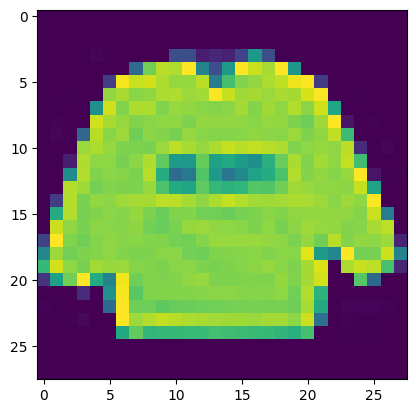

In [ ]:
a = np.array(df.iloc[0,1:]).reshape(28,28)
plt.imshow(a)

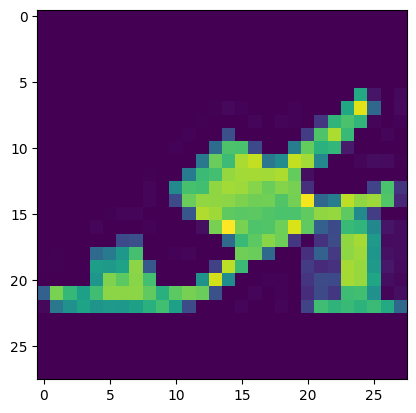

In [ ]:
a = np.array(df.iloc[50,1:]).reshape(28,28)
plt.imshow(a)

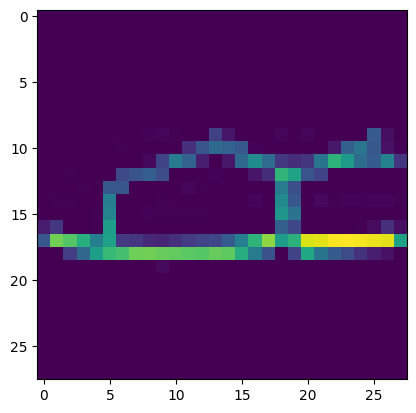

In [ ]:
a = np.array(df.iloc[970,1:]).reshape(28,28)
plt.imshow(a)

In [ ]:
x = df.iloc[:,1:]
y = df.iloc[:,0]

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.2,random_state=42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
#scaling

x_train = x_train/255
x_test = x_test/255

In [ ]:
x_train.shape

(1509, 784)

In [ ]:
x_test.shape

(378, 784)

### *Custom Dataset Class*

In [ ]:
class Data_Set_Custom(Dataset):

  # constructor
  def __init__(self,features,labels):
    super().__init__()

    self.features = torch.tensor(np.array(features),dtype=torch.float32)
    self.labels = torch.tensor(np.array(labels),dtype=torch.long)


  # len function

  def __len__(self):
    return len(self.features)

  # get item function

  def __getitem__(self, index) :
    return self.features[index],self.labels[index]



In [ ]:
# object creation of custom data
train_data = Data_Set_Custom(x_train,y_train)
test_data = Data_Set_Custom(x_test,y_test)

### **DataLoader**

In [ ]:
# Data loader

train_loader = DataLoader(train_data,batch_size=64,shuffle=True,pin_memory=True)
test_loader = DataLoader(test_data,batch_size=64,shuffle=False,pin_memory=True)

### **MODEL DESIGN**

In [ ]:
class ANN(nn.Module):

  def __init__(self,input_dim,output_dim, num_hidden_layer,neuron_per_hidden_layer):
    super().__init__()

    layers =[]
    for i in range(num_hidden_layer):

        layers.append(nn.Linear(input_dim,neuron_per_hidden_layer))
        layers.append(nn.BatchNorm1d(neuron_per_hidden_layer))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.3))
        input_dim = neuron_per_hidden_layer

    layers.append(nn.Linear(neuron_per_hidden_layer,output_dim))

    self.ann = nn.Sequential(*layers)

  def forward(self,x):

    return self.ann(x)




## **Objective function**

In [ ]:
class Objective(trial):

  num_hidden_layer = trial.suggest_int('num_hidden_layer',1,5)
  neuron_per_hidden_layer = trial.suggest_int('neuron_per_hidden_layer',8,128,step=8)


  input_dim = 784
  output_dim = 10

  # object creation of model
  model = ANN(input_dim,output_dim,num_hidden_layer,neuron_per_hidden_layer)
  model.to(device)

  # parameters
  learning_rate = 0.1
  epochs = 2

  # optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(),lr = learning_rate,weight_decay=1e-5)



  # training loop
  for epoch in range(epochs):
    total_epoch_loss =0
    for batch_feature,batch_labels in train_loader:
      batch_feature,batch_labels = batch_feature.to(device),batch_labels.to(device)

      # forward
      y_pred= model(batch_feature)

      # loss
      loss = criterion(y_pred,batch_labels)

      # backward pass
      optimizer.zero_grad()
      loss.backward()

      # updating parameter
      optimizer.step()

      total_epoch_loss = total_epoch_loss +loss.item()


  # evaluation
  model.eval()

  total = 0
  correct =0

  with torch.no_grad():
    for batch_features,batch_labels in test_loader:
      batch_features,batch_labels = batch_features.to(device), batch_labels.to(device)

      y_pred = model(batch_features)

      _,predicted = torch.max(y_pred,1)

      total = total + batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()
  accuracy = correct/total

  return accuracy








SyntaxError: 'return' outside function (<ipython-input-20-cad69ab41325>, line 66)

In [ ]:
def Objective(trial):
    num_hidden_layer = trial.suggest_int('num_hidden_layer', 1, 5)
    neuron_per_hidden_layer = trial.suggest_int('neuron_per_hidden_layer', 8, 128, step=8)

    input_dim = 784
    output_dim = 10

    # object creation of model
    model = ANN(input_dim, output_dim, num_hidden_layer, neuron_per_hidden_layer)
    model.to(device)

    # parameters
    learning_rate = 0.1
    epochs = 2

    # optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # training loop
    for epoch in range(epochs):
        total_epoch_loss = 0
        for batch_feature, batch_labels in train_loader:
            batch_feature, batch_labels = batch_feature.to(device), batch_labels.to(device)

            # forward
            y_pred = model(batch_feature)

            # loss
            loss = criterion(y_pred, batch_labels)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # updating parameter
            optimizer.step()

            total_epoch_loss += loss.item()

    # evaluation
    model.eval()
    total = 0
    correct = 0

    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            y_pred = model(batch_features)
            _, predicted = torch.max(y_pred, 1)
            total += batch_labels.shape[0]
            correct += (predicted == batch_labels).sum().item()

    accuracy = correct / total
    return accuracy


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.9 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
study = optuna.create_study(direction='maximize')

[I 2025-02-25 06:56:03,481] A new study created in memory with name: no-name-c6e655dc-38ce-452c-ba72-499401d0a27f


In [ ]:
study.optimize(Objective,n_trials=5)

[W 2025-02-25 06:57:04,067] Trial 0 failed with parameters: {'num_hidden_layer': 3, 'neuron_per_hidden_layer': 72} because of the following error: NameError("name 'device' is not defined").
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-21-d6954f403926>", line 10, in Objective
    model.to(device)
             ^^^^^^
NameError: name 'device' is not defined
[W 2025-02-25 06:57:04,068] Trial 0 failed with value None.


NameError: name 'device' is not defined